In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import pickle
import sys

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool1D,
)

2024-05-21 06:15:01.584642: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 06:15:01.613772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 06:15:01.613805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 06:15:01.614593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 06:15:01.619108: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-21 06:15:02.729423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 06:15:02.755898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 06:15:02.756107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
emotion_list = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgusted",
    7: "surprised",
}

In [5]:
def plot_network_history(network_history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(network_history.history["loss"], label="Training Loss")
    axes[0].plot(network_history.history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(
        network_history.history["categorical_accuracy"],
        label="Training Categorical Accuracy",
    )
    axes[1].plot(
        network_history.history["val_categorical_accuracy"],
        label="Validation Categorical Accuracy",
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

In [6]:
log_dir = "runs/lstm_n_conv_og_data"
with open("./data/processed_data.pickle", "rb") as f:
    data = pickle.load(f)
X_train = data["X_train"]
X_test = data["X_test"]
Y_train = data["Y_train"]
Y_test = data["Y_test"]

In [7]:
X_train.shape

(12000, 40, 1)

In [8]:
print(gc.collect())
K.clear_session()

num_classes = len(Y_test[0])
model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    #
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    MaxPool1D(pool_size=2, padding="same"),
    Dropout(0.3),
    #
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    Dropout(0.3),
    #
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    MaxPool1D(pool_size=2, padding="same"),
    Dropout(0.3),
    #
    LSTM(1024),
    # Bidirectional(LSTM(1, return_sequences=True)),
    # Bidirectional(LSTM(1024)),
    #
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dense(num_classes, activation="softmax"),
]

model = tf.keras.Sequential(layers)
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

0


2024-05-21 06:15:02.991427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 06:15:02.991654: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 06:15:02.991769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 200)           800       
                                                                 
 batch_normalization (Batch  (None, 38, 200)           800       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 200)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 19, 200)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 200)           120200    
                                                                 
 batch_normalization_1 (Bat  (None, 17, 200)          

In [9]:
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0.00005,
    patience=15,
    restore_best_weights=True,
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.3,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq="epoch")

network_history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        es,
        lr_scheduler,
        tensorboard_callback,
    ],
)

Epoch 1/200


2024-05-21 06:15:06.443996: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-21 06:15:07.501460: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe127a3bc40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 06:15:07.501490: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-21 06:15:07.506329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716264907.558801   20446 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - 6s 12ms/step - loss: 1.9122 - categorical_accuracy: 0.2746 - val_loss: 1.8997 - val_categorical_accuracy: 0.2146 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 1s 8ms/step - loss: 1.6909 - categorical_accuracy: 0.3606 - val_loss: 1.7080 - val_categorical_accuracy: 0.3433 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 1s 8ms/step - loss: 1.5939 - categorical_accuracy: 0.3942 - val_loss: 1.6026 - val_categorical_accuracy: 0.4267 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 1s 8ms/step - loss: 1.4888 - categorical_accuracy: 0.4370 - val_loss: 1.5809 - val_categorical_accuracy: 0.4292 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 1s 8ms/step - loss: 1.4042 - categorical_accuracy: 0.4752 - val_loss: 1.3497 - val_categorical_accuracy: 0.5017 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 1s 8ms/step - loss: 1.2899 - categorical_accuracy: 0.516

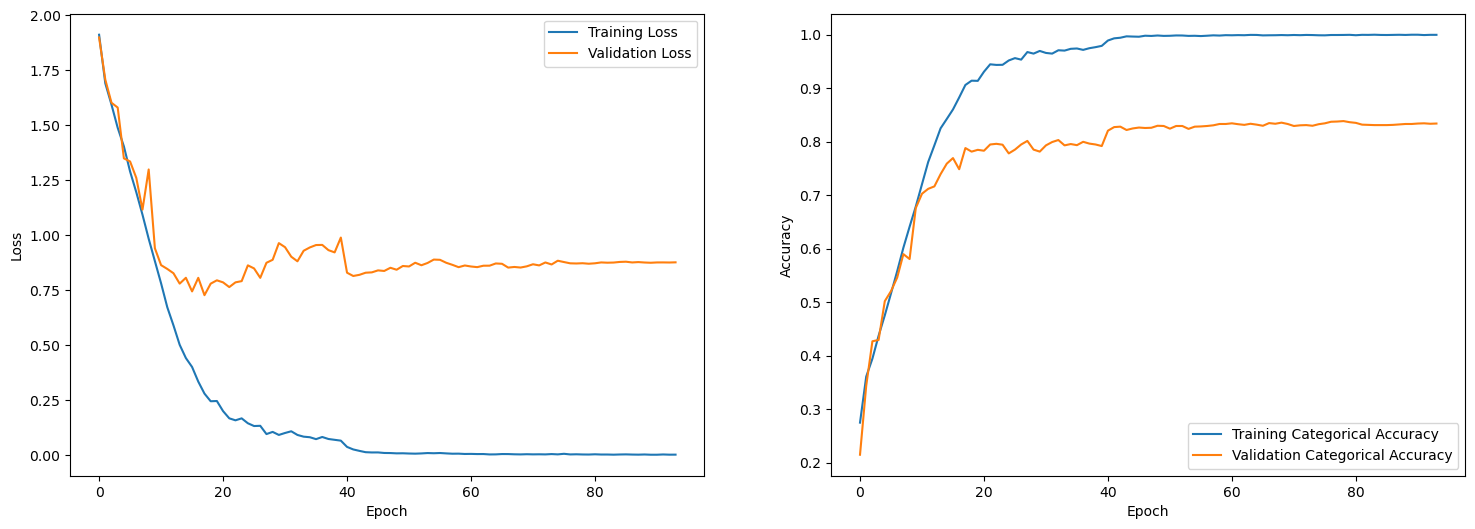

In [10]:
plot_network_history(network_history)

In [11]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
preds = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [12]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_true = np.argmax(Y_test, 1)

print("Test accuracy: %g" % (accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))

9/9 [==============================] - 0s 2ms/step
Test accuracy: 0.670139
Precision 0.6719139327242525
Recall 0.667242888941094
f1_score 0.6677573064129005


In [13]:
print(
    classification_report(y_true, y_pred, target_names=emotion_list.values(), digits=4)
)

              precision    recall  f1-score   support

     neutral     0.7500    0.6316    0.6857        19
        calm     0.8000    0.8780    0.8372        41
       happy     0.6286    0.6111    0.6197        36
         sad     0.6429    0.6923    0.6667        39
       angry     0.6190    0.7027    0.6582        37
     fearful     0.6667    0.6875    0.6769        32
   disgusted     0.5938    0.5429    0.5672        35
   surprised     0.6744    0.5918    0.6304        49

    accuracy                         0.6701       288
   macro avg     0.6719    0.6672    0.6678       288
weighted avg     0.6695    0.6701    0.6681       288



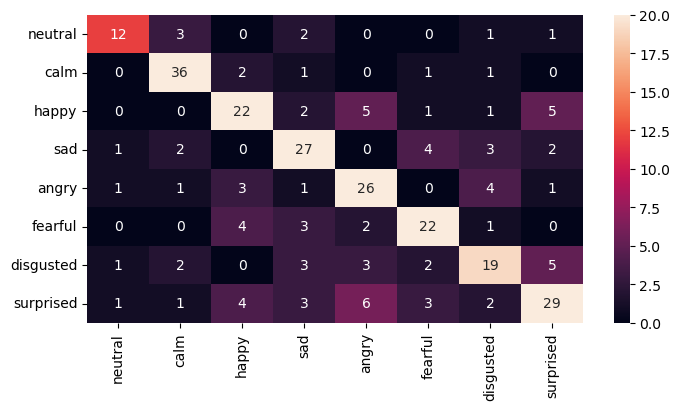

In [14]:
plt.figure(figsize=(8, 4))
conf = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

In [15]:
model.save(f"./models/{log_dir.split('/')[-1]}.keras")